##  Importando libs

In [1]:
import boto3
import logging
import os
import time
import datetime
import mysql.connector
from mysql.connector import Error
from functools import partial
from botocore.exceptions import ClientError

##  Credenciais no boto3 e configurando ambiente AWS:

https://docs.aws.amazon.com/pt_br/cli/latest/userguide/cli-chap-configure.html

Para conectar-se à AWS usando o Boto3, é necessário fornecer as credenciais de acesso e configurar a região na qual deseja operar. Existem três maneiras para fazer a conexão, eu utilizei as credenciais cadastradas como variáveis de ambiente no meu OS via linha de comando.

Ao definir as variáveis de ambiente **AWS_ACCESS_KEY_ID** e **AWS_SECRET_ACCESS_KEY** com suas respectivas chaves de acesso, o Boto3 usará automaticamente essas credenciais ao estabelecer a conexão com os serviços da AWS.

Observação: Praticamente todos serviços utilizador requerem configuração de roles e grupos de segurança, essa parte dos detalhes não foi abordado aqui no notebook.

In [2]:
# Conexão AWS via as credenciais como variáveis de ambiente
try:
    session = boto3.Session()
    print("Conexão com a AWS estabelecida com sucesso!")
except Exception as e:
    print("Erro na conexão com a AWS:", str(e))

Conexão com a AWS estabelecida com sucesso!


In [3]:
# Client para serviços da AWS que vão ser utilizados
s3_client = session.client('s3')
rds_client = session.client('rds')
glue_client = boto3.client("glue")

### Criando bucket no AWS S3:

In [4]:
# Função com configurações para criar o bucket
def criar_bucket(bucket_name, region):
    try:
        if region == 'us-east-1':
            client_cli = boto3.client('s3')
            response = client_cli.create_bucket(Bucket = bucket_name, ACL = 'private')
        else:
            client_cli = boto3.client('s3', region_name = region)
            location = {'LocationConstraint': region}
            response = client_cli.create_bucket(Bucket = bucket_name, CreateBucketConfiguration = location, ACL = 'private')
    except ClientError as e:
        logging.error(e)
        return False
    print('Bucket created ID AWS: ' + (response['ResponseMetadata']['HTTPHeaders']['x-amz-request-id']))

In [5]:
# Usando a função para criar o bucket
bucket_name = 'arquivos-medland'
criar_bucket(bucket_name, 'us-east-1')

Bucket created ID AWS: EPNPGC85F1162RVQ


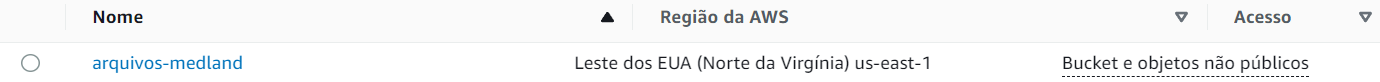

###  Upload dos arquivos no bucket S3 utilizando uma lista com nome dos arquivos:


In [6]:
# Lista com caminho e nome dos arquivos que quero subir para o S3 
lista_arquivos = ['./pacientes_f.json', './pacientes_m.json', './consultas.csv']

In [7]:
# Função para fazer upload dos arquivos
def upload_arq_raw(file_name, bucket, object_name = None):
    try:
        client_cli = boto3.client('s3')
    
    # Se S3 object_name não foi especificado usar file_name,'raw/' determina a pasta no s3
        if object_name is None:
            object_name = 'Raw data/' + os.path.basename(file_name)
            # Carregar o arquivo
        response = client_cli.upload_file(file_name, bucket, object_name)
        print('Upload successfully to S3!')
    except Exception as e:
        print(f'Error sending to S3: {str(e)}')

# Ajuste da função criada para fazer um map fixando o parâmetro bucket
upload_arq_raw2 = partial(upload_arq_raw, bucket = bucket_name)

In [8]:
# Utilizando MAP para aplicar a função upload_arq_raw2 em cada elemento da lista_arquivos
upload = list(map(upload_arq_raw2, lista_arquivos))

Upload successfully to S3!
Upload successfully to S3!
Upload successfully to S3!


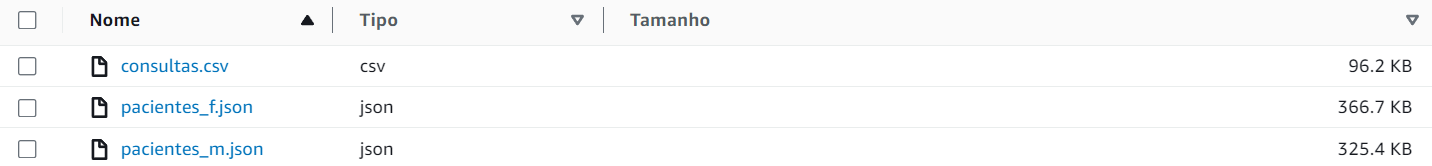

### Criando pasta no bucket para receber arquivos processados:

In [9]:
def insert_folders3(bucket, folder):
    try:
        # Add uma barra no final do nome se não estiver presente, para garantir que seja tratada como uma pasta pelo S3
        if not folder.endswith('/'):
            folder += '/'
        client_cli = boto3.client('s3')
        response = client_cli.put_object(Bucket = bucket, Key = folder)
    except ClientError as e:
        logging.error(e)
        return False
    print(f'Folder {folder} created! AWS ID: ' + (response['ResponseMetadata']['HTTPHeaders']['x-amz-request-id']))

In [10]:
# Criando pasta para colocar os dados processados posteriormente
insert_folders3(bucket_name, 'ProcessedData')

Folder ProcessedData/ created! AWS ID: 3MMS63YABJ0X871K


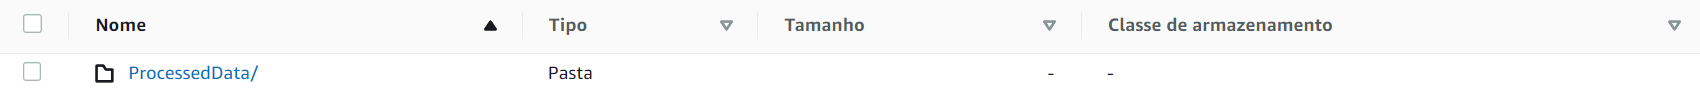

### Criando instância para banco de dados MySQL no AWS RDS:

In [11]:
# Variável para definir nome da instância
nome_instancia = 'database-medland'

try:
    # Criei a instância usando um grupo de segurança criado com regra de entrada liberada somente para meu IP
    response = rds_client.create_db_instance(
        AllocatedStorage = 15,
        DBInstanceClass = 'db.t2.micro',
        DBInstanceIdentifier = nome_instancia,
        Engine = 'MySQL',
        DBName = 'hospital',
        LicenseModel = 'general-public-license',
        MasterUsername = 'root',
        MasterUserPassword = 'pass54word23',
        AvailabilityZone = 'us-east-1a',
        PubliclyAccessible = True,
        DeletionProtection = False,  # Habilitar como true!!
        BackupRetentionPeriod = 7,
        VpcSecurityGroupIds = ['sg-07dfd90bcce842634']
    )

    print('Instance RDS: {} successfully created!'.format(response['DBInstance']['DBInstanceIdentifier']))
except Exception as e:
    print(f'Error creating instance: {str(e)}')

Instance RDS: database-medland successfully created!


- `AllocatedStorage`: Especifica o tamanho do armazenamento alocado para a instância em gigabytes (GB).
- `DBInstanceClass`: Define a classe da instância do banco de dados, no caso 'db.t2.micro', que é uma instância de baixo custo com recursos limitados.
- `DBInstanceIdentifier`: Identificador único para a instância do banco de dados.
- `Engine`: Indica o tipo de mecanismo de banco de dados a ser usado, neste caso, 'MySQL'.
- `DBName`: O nome do banco de dados a ser criado.
- `LicenseModel`: Define o modelo de licença do banco de dados, neste caso, 'general-public-license'.
- `MasterUsername`: O nome do usuário mestre para o banco de dados.
- `MasterUserPassword`: A senha do usuário mestre para o banco de dados.
- `AvailabilityZone`: Especifica a zona de disponibilidade na qual a instância do banco de dados será criada.
- `PubliclyAccessible`: Indica se a instância do banco de dados pode ser acessada publicamente pela internet.
- `DeletionProtection`: Define se a proteção contra exclusão está habilitada ou desabilitada para a instância do banco de dados.
- `BackupRetentionPeriod`: Especifica o período de retenção para os backups automatizados da instância do banco de dados, em dias.
- `VpcSecurityGroupIds`: Lista de IDs dos grupos de segurança da VPC que serão associados à instância do banco de dados.

In [12]:
# Verificando estado da instância
while True:
    # Chamar a função describe_db_instances() para obter informações da instância
    response = rds_client.describe_db_instances(DBInstanceIdentifier = nome_instancia)

    # Verificar o estado da instância
    db_instance = response['DBInstances'][0]
    state = db_instance['DBInstanceStatus']
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'State of the RDS instance at the moment: {state} in {current_time}')

    # Verificar se a instância está criada
    if state == 'available':
        print(f'\nThe instance is now available!')
        break

    # Aguardar 300 segundos antes de verificar novamente
    time.sleep(300)

State of the RDS instance at the moment: creating in 2023-09-16 21:45:05
State of the RDS instance at the moment: backing-up in 2023-09-16 21:50:06
State of the RDS instance at the moment: available in 2023-09-16 21:55:07

The instance is now available!


In [13]:
# Obtendo o endpoint (host) da  instância RDS que foi criada
# Será usado na conexão do banco de dados, então é mais fácil já armazenar em uma variável
my_host = (response['DBInstances'][0]['Endpoint']['Address'])
print(my_host)

database-medland.cahhgseg4vc5.us-east-1.rds.amazonaws.com


### CRUD para criar tabelas e já inserir alguns dados no banco de dados:

In [14]:
# Primeiro passo fazer a conexão com o banco de dados
try:
    connection = mysql.connector.connect(
    host = my_host,
    user = 'root',
    password = 'pass54word23',
    database = 'hospital'
)
    if connection.is_connected():
        db_info = connection.get_server_info()
        print('Connected to MySQL Server version database', db_info)
        cursor = connection.cursor()
except Error as e:
    print('Error connecting to database:', e)

Connected to MySQL Server version database 8.0.33


### Feita a conexão, criamos as tabelas especificando o nome e esquema(schema) de cada uma:

In [15]:
# Tabela PACIENTES
cursor.execute('''
CREATE TABLE PACIENTES (
    ID_PACIENTE INT AUTO_INCREMENT,
    NOME VARCHAR(100),
    SEXO ENUM('F','M'),
    TP_SANGUE ENUM('A+','A-','B+','B-','AB+','AB-','O+','O-'),
    RG VARCHAR(9),
    CPF VARCHAR(11),
    NASCIMENTO DATE,
    NOME_MAE VARCHAR(100),
    TELEFONE VARCHAR(15),
    EMAIL VARCHAR(150),
    ENDERECO VARCHAR(150),
    CEP VARCHAR(9),
    CIDADE VARCHAR(25),
    ESTADO CHAR(2),
    CONSTRAINT PK_PACIENTES PRIMARY KEY (ID_PACIENTE)
)
''')

# Tabela HOSPITAIS
cursor.execute('''
CREATE TABLE HOSPITAIS (
    ID_HOSPITAL INT NOT NULL AUTO_INCREMENT,
    NOME VARCHAR(100),
    DESCRICAO VARCHAR(100),
    TELEFONE VARCHAR(15),
    ENDERECO VARCHAR(180),
    CEP VARCHAR(9),
    CIDADE VARCHAR(50),
    ESTADO CHAR(2),
    CNPJ VARCHAR(18),
    CONSTRAINT PK_HOSPITAIS PRIMARY KEY (ID_HOSPITAL)
)
''')

# Tabela CONSULTAS
cursor.execute('''
CREATE TABLE CONSULTAS (
    ID_CONSULTA INT AUTO_INCREMENT,
    ID_PACIENTE INT,
    ID_MEDICO INT,
    ID_HOSPITAL INT,
    DATA DATETIME,
    GRAU_RISCO TINYINT,
    DIAGNOSTICO VARCHAR(50),
    INTERNACAO TINYINT(1),
    CONSTRAINT PK_CONSULTAS PRIMARY KEY (ID_CONSULTA)
)
''')

# Tabela MEDICOS
cursor.execute('''
CREATE TABLE MEDICOS (
    ID_MEDICO INT AUTO_INCREMENT,
    NOME VARCHAR(40),
    SEXO ENUM('F','M'),
    ESPECIALIDADE VARCHAR(30),
    CRM VARCHAR(15),
    TELEFONE VARCHAR(20),
    CONSTRAINT PK_MEDICOS PRIMARY KEY (ID_MEDICO)
)
''')

# Tabela INTERNACOES
cursor.execute('''
CREATE TABLE INTERNACOES (
    ID_INTERNACAO INT AUTO_INCREMENT,
    ID_CONSULTA INT UNIQUE,
    QUARTO INT,
    ENTRADA DATETIME,
    SAIDA DATETIME,
    CONSTRAINT PK_INTERNACOES PRIMARY KEY (ID_INTERNACAO)
)
''')

# Commit para confirmar e persistir as alterações no banco de dados
# Sem ele, as alterações realizadas durante a transação não são permanentes e são desfeitas ao final da conexão!

connection.commit()

In [16]:
# Verificando tabelas criadas com show tables
cursor.execute('SHOW TABLES')
tables = cursor.fetchall()

print('Database tables:\n')
for table in tables:
    print('->', table[0].decode())

Database tables:

-> CONSULTAS
-> HOSPITAIS
-> INTERNACOES
-> MEDICOS
-> PACIENTES


### Definindo constraints de chaves estrangeiras e check:

In [17]:
# Adicionar constraint FK_CONSULTA_PACIENTE na tabela CONSULTAS
cursor.execute("""
ALTER TABLE CONSULTAS 
ADD CONSTRAINT FK_CONSULTA_PACIENTE
FOREIGN KEY(ID_PACIENTE) REFERENCES PACIENTES(ID_PACIENTE)
""")

# Adicionar constraint FK_CONSULTA_MEDICO na tabela CONSULTAS
cursor.execute("""
ALTER TABLE CONSULTAS 
ADD CONSTRAINT FK_CONSULTA_MEDICO
FOREIGN KEY(ID_MEDICO) REFERENCES MEDICOS(ID_MEDICO)
""")

# Adicionar constraint FK_CONSULTA_HOSPITAL na tabela CONSULTAS
cursor.execute("""
ALTER TABLE CONSULTAS 
ADD CONSTRAINT FK_CONSULTA_HOSPITAL
FOREIGN KEY(ID_HOSPITAL) REFERENCES HOSPITAIS(ID_HOSPITAL)
""")

# Adicionar constraint FK_INTERNACAO_CONSULTA na tabela INTERNACAO
cursor.execute("""
ALTER TABLE INTERNACOES 
ADD CONSTRAINT FK_INTERNACAO_CONSULTA
FOREIGN KEY(ID_CONSULTA) REFERENCES CONSULTAS(ID_CONSULTA)
""")

# Adicionar constraint CHECK_TRIAGEM na tabela CONSULTAS limitando a coluna GRAU_RISCO com valor entre 1 e 5
cursor.execute("""
ALTER TABLE CONSULTAS 
ADD CONSTRAINT CHECK_TRIAGEM
CHECK (GRAU_RISCO BETWEEN 1 AND 5)
""")

# Confirmar as alterações no banco de dados
connection.commit()

In [18]:
# Executar a consulta SQL para verificar as constraints
cursor.execute("""
    SELECT
        CONSTRAINT_NAME,
        TABLE_NAME,
        CONSTRAINT_TYPE
    FROM
        INFORMATION_SCHEMA.TABLE_CONSTRAINTS
    WHERE
        TABLE_SCHEMA = 'hospital'
        AND (CONSTRAINT_TYPE = 'FOREIGN KEY' OR CONSTRAINT_TYPE = 'CHECK')
    ORDER BY
        CONSTRAINT_NAME
""")

# Recuperar os resultados da consulta
results = cursor.fetchall()

# Exibir os resultados
for row in results:
    print("Constraint type:", row[2].decode() + " | Constraint Name:", row[0] + " | Table:", row[1].decode())

Constraint type: CHECK | Constraint Name: CHECK_TRIAGEM | Table: CONSULTAS
Constraint type: FOREIGN KEY | Constraint Name: FK_CONSULTA_HOSPITAL | Table: CONSULTAS
Constraint type: FOREIGN KEY | Constraint Name: FK_CONSULTA_MEDICO | Table: CONSULTAS
Constraint type: FOREIGN KEY | Constraint Name: FK_CONSULTA_PACIENTE | Table: CONSULTAS
Constraint type: FOREIGN KEY | Constraint Name: FK_INTERNACAO_CONSULTA | Table: INTERNACOES


### Tabela HOSPITAIS: Dados inseridos a partir de uma query insert

In [19]:
# Inserindo dados da unidade Luxemburgo
cursor.execute('''
INSERT INTO HOSPITAIS (nome, descricao, telefone, endereco, cep, cidade, estado, cnpj)
VALUES ('Fundação Hospital MedLand', 'Unidade Luxemburgo', '(31)2545-0946', 'R. Gentios - 1523 Luxemburgo', '30380-472', 'Belo Horizonte', 'MG', '52.171.254/0001-76')
''')

# Inserindo dados da unidade Área hospitalar
cursor.execute('''
INSERT INTO HOSPITAIS (nome, descricao, telefone, endereco, cep, cidade, estado, cnpj)
VALUES ('Fundação Hospital MedLand', 'Unidade Área Hospitalar', '(31)2684-9094', 'Av. Churchil 230 - Santa Efigênia', '30260-080', 'Belo Horizonte', 'MG', '52.171.254/0001-55')
''')

connection.commit()

In [20]:
# Query para checkar dados
query_hp = "SELECT * FROM HOSPITAIS"
cursor.execute(query_hp)
results = cursor.fetchall()

for row in results:
    print(row)

(1, 'Fundação Hospital MedLand', 'Unidade Luxemburgo', '(31)2545-0946', 'R. Gentios - 1523 Luxemburgo', '30380-472', 'Belo Horizonte', 'MG', '52.171.254/0001-76')
(2, 'Fundação Hospital MedLand', 'Unidade Área Hospitalar', '(31)2684-9094', 'Av. Churchil 230 - Santa Efigênia', '30260-080', 'Belo Horizonte', 'MG', '52.171.254/0001-55')


### Tabela MÉDICOS: Lendo um TXT desestruturado e inserindo no banco de dados

In [21]:
# Carregando arquivo local:
arquivo = open("medicos.txt")

# Lista vazia
medicos = []

# Loop para adicionar cada lista do meu arquivo que contenha exatamente 5 itens dentro da variável medicos:
for linha in arquivo:
    linha_lista = [item.strip() for item in linha.split(',')]
    if len(linha_lista) == 5:
        medicos.append(linha_lista)

Explicação detalhada do que o loop for faz:

1. O loop percorre cada linha no arquivo.
2. Para cada linha, a variável `linha_lista` é criada, que é uma lista contendo os itens da linha. Isso é feito usando a função `split(',')`, que divide a linha em itens usando a vírgula como separador, e a compreensão de lista `[item.strip() for item in linha.split(',')]`, que remove os espaços em branco adicionais em cada item usando o método `strip()`.
3. A condição `if len(linha_lista) == 5` verifica se a linha possui exatamente 5 itens.
4. Se a condição for verdadeira, ou seja, se a linha tiver exatamente 5 itens, a linha é adicionada à lista `medicos` usando o método `append()`.

Ao final da execução desse loop, a lista `medicos` conterá apenas as linhas do arquivo que possuem exatamente 5 itens.

In [22]:
# Pegando a lista do index 1 para frente para ignorar o cabeçalho do arquivo
dados = medicos[1:]

# Insere cada linha da lista na tabela do banco de dados
for linha in dados:
    cursor.execute("INSERT INTO MEDICOS (NOME, SEXO, ESPECIALIDADE, CRM, TELEFONE) VALUES (%s, %s, %s, %s, %s)", linha)
connection.commit()

In [23]:
# Query para checkar dados
query = "SELECT * FROM MEDICOS"
cursor.execute(query)
results = cursor.fetchall()

for row in results:
    print(row)

(1, 'Anthony Alex de Castro', 'M', 'Cardiologista', 'CRM/MG 568956', '(31)99129-6532')
(2, 'Gabriely Santos Mizoni', 'F', 'Geral', 'CRM/SP 985236', '(31)99156-2798')
(3, 'Alex Freire', 'M', 'Dermatologista', 'CRM/MG 589126', '(31)98991-2023')
(4, 'Cristina Cardeal Ramos', 'F', 'Geral', 'CRM/RJ 236159', '(21)99130-2710')
(5, 'Guilherme Cherpak', 'M', 'Ortopedista', 'CRM/SP 235154', '(11)98734-7880')
(6, 'Pedro Diniz Kimura', 'M', 'Otorrino', 'CRM/ES 354065', '(27)99542-7746')
(7, 'Julia Torritani Dias', 'F', 'Geral', 'CRM/MG 985163', '(31)98836-0932')
(8, 'Adriana Coelho Lamberti', 'F', 'Cardiologista', 'CRM/MG 542148', '(31)99854-8699')
(9, 'Roberto Furst Macedo', 'M', 'Geral', 'CRM/MG 124786', '(31)98975-5088')
(10, 'Ana Carolina Giotto', 'F', 'Oftalmologia', 'CRM/SP 269148', '(11)98723-7341')


### Tabela INTERNAÇÕES: Lendo CSV e tratando com Pandas

Observação: A tabela será apenas criada e os dados serão inseridos posteriormente. A tabela possui uma restrição de chave estrangeira que é uma chave primária em uma tabela na qual os dados ainda não foram inseridos, se tentar o insert agora teremos um erro. Os dados da entidade CONSULTAS serão inseridos serão inseridos posteriormente usando o JOB ETL do AWS Glue.

In [24]:
import pandas as pd

# Abrir o arquivo CSV com pandas
df_inter = pd.read_csv("internacoes.csv", sep = ";")

# Exibir o DataFrame resultante
df_inter.head()

,ID_CONSULTA,QUARTO,ENTRADA,SAIDA
0,5,7,10/01/2022 09:28,13/01/2022 11:36
1,6,1,10/01/2022 11:44,16/01/2022 22:29
2,8,3,11/01/2022 13:06,12/01/2022 14:59
3,10,6,14/01/2022 09:31,21/01/2022 11:30
4,11,2,14/01/2022 10:23,19/01/2022 05:52


In [25]:
# Convertendo as datas de string para datetime:
df_inter['ENTRADA'] = pd.to_datetime(df_inter['ENTRADA'], format='%d/%m/%Y %H:%M')
df_inter['SAIDA'] = pd.to_datetime(df_inter['SAIDA'], format='%d/%m/%Y %H:%M')


# Formatando as datas como string no formato "%Y-%m-%d %H:%M:%S"
df_inter['ENTRADA'] = df_inter['ENTRADA'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_inter['SAIDA'] = df_inter['SAIDA'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [26]:
# Conferindo o schema
print(df_inter.dtypes)

ID_CONSULTA     int64
QUARTO          int64
ENTRADA        object
SAIDA          object
dtype: object


In [27]:
df_inter

,ID_CONSULTA,QUARTO,ENTRADA,SAIDA
0,5,7,2022-01-10 09:28:00,2022-01-13 11:36:00
1,6,1,2022-01-10 11:44:00,2022-01-16 22:29:00
2,8,3,2022-01-11 13:06:00,2022-01-12 14:59:00
3,10,6,2022-01-14 09:31:00,2022-01-21 11:30:00
4,11,2,2022-01-14 10:23:00,2022-01-19 05:52:00
...,...,...,...,...
481,1592,9,2023-09-20 11:47:00,2023-09-25 15:23:00
482,1594,3,2023-09-21 04:00:00,2023-09-26 07:36:00
483,1600,2,2023-09-22 05:26:00,2023-09-25 10:14:00
484,1606,10,2023-09-23 03:53:00,2023-09-27 11:05:00


## Agora partimos para a AWS GLUE!

### Etapa 1: Acionar JOB 1 Glue para tratar os dados raw.

Acionamos um JOB com notebook Jupyter usando o Spark para tratar e enriquecer os dados que foram carregados para o bucket na pasta 'Raw Data', depois ele salva os dois dados como parquet na pasta que criamos anteriormente para os dados processados.

O notebook desse JOB você encontra no repositório com o nome `JOB1.ipynb`

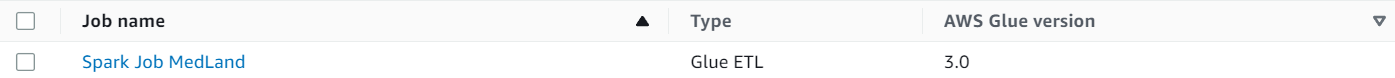

In [28]:
# Função para acionar JOB Glue

def run_glue_job(job_name):
    try:
        response = glue_client.start_job_run(JobName = job_name)
        job_run_id = response["JobRunId"]
        print("Job run ID: " + job_run_id + " at " + response["ResponseMetadata"]["HTTPHeaders"]["date"])
    
        while True:
            response = glue_client.get_job_run(JobName = job_name, RunId = job_run_id)
            status = response["JobRun"]["JobRunState"]
    
            if status == "SUCCEEDED":
                print(f"Finished status: {status}")
                break
        
            elif status == "FAILED":
                print(f"Finished status: {status},{response['JobRun']['ErrorMessage']}")
                break
    
            # Esperar 60 segundos antes de verificar novamente
            time.sleep(60)
    
    except Exception as e:
        print("Error running job:", str(e))

In [29]:
# Rodando primeiro job
glue_job1 = ("Spark Job MedLand")
run_glue_job(glue_job1)

Job run ID: jr_7ddc8c4d1ade5c1e84f451976a3ebca1bff8398f0790210dbb2943946fbe9214 at Sun, 17 Sep 2023 00:55:13 GMT
Finished status: SUCCEEDED


### Etapa 2: Criar conexão e crawlers para catalogar dados.

Dois crawlers ou "rastreadores" são criados no AWS Glue.
<ul>
<li><strong>processed data medland</strong></li>
Esse vai varrer a pasta (arquivos-medland/ProcessedData) do nosso bucket, que o job 1 criou para armazenar os dados processados.
Nessa pasta vão estar os dois arquivos parquet tratados e enriquecidos para duas tabelas do banco de dados, PACIENTES e CONSULTAS.
<ol>
</ol>
<li><strong>rds medland tables</strong></li>
Já esse, através de uma conexão do Glue com o banco de dados RDS, vai varrer e catalogar os atributos das entidades (tabelas) PACIENTES e CONSULTAS lá no banco, isso vai ser o nosso TARGET. 

Depois de tudo catalogado, criaremos um outro job GLUE para movimentar os dados das fontes "sources" até os alvos "targets" que no caso é o nosso banco de dados MySql RDS.

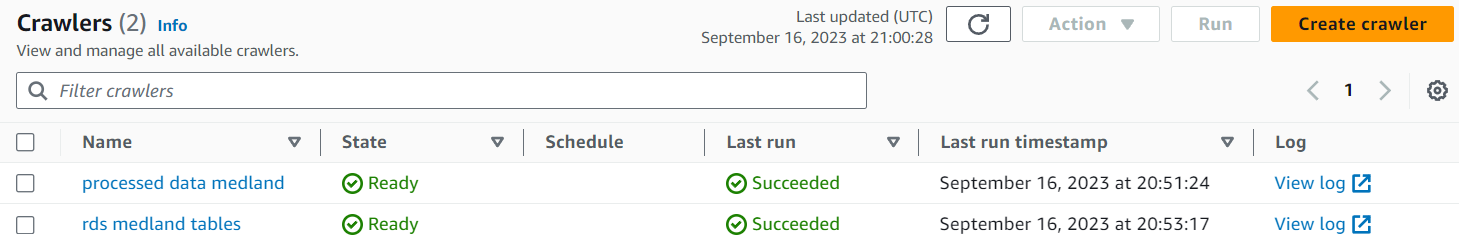

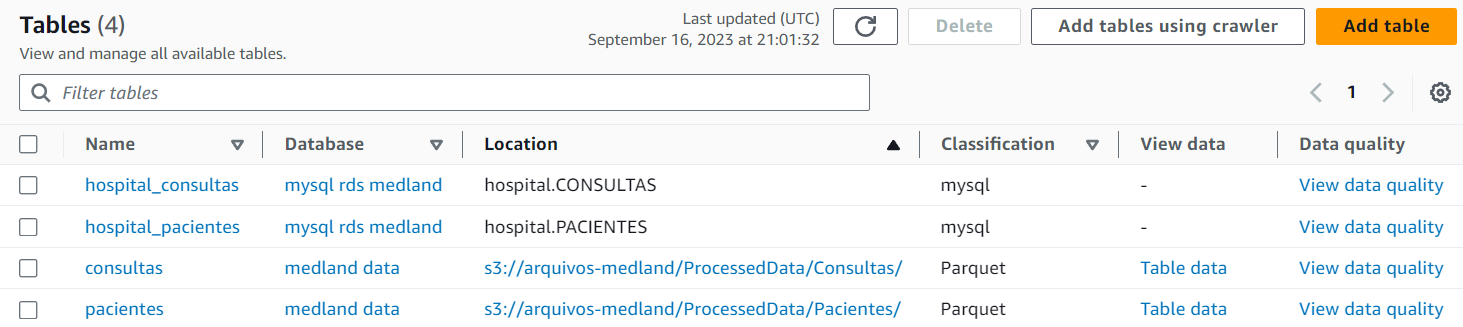

In [30]:
# Criando função para rodar crawler
def crawler_run(crawler_name):
    response = glue_client.start_crawler(Name = crawler_name)
    
    # Se o retorno for 200 crawler rodou, caso contrário erro
    if response["ResponseMetadata"]["HTTPStatusCode"] == 200:
        print(f"Crawler running, please wait...")
    else:
        print(f"Erro to launch crawler {crawler_name}.")
        
        # Loop para conferir se o crawler vai rodar
    while True:
        # Obter o status do crawler
        crawler_response = glue_client.get_crawler(Name = crawler_name)
        crawler_status = crawler_response["Crawler"]["State"]
        
        # Verificar se o crawler está pronto
        if crawler_status == "READY":
            print(f"Finished, Status: {crawler_status}")
            break
        
        elif crawler_status == "FAILED":
            print(f"Finished with error! Status: {crawler_status}")
            break
        
        # Aguardar 120 segundos antes de verificar o status novamente
        time.sleep(120)

In [31]:
# Definindo nome dos crawlers
crawler_arquivos = 'processed data medland'
crawler_tabelasdb = 'rds medland tables'

In [32]:
# Rodando crawler dos arquivos com a função criada
crawler_run(crawler_arquivos)

Crawler running, please wait...
Finished, Status: READY


In [33]:
# Rodando crawler das tabelas com a função criada
crawler_run(crawler_tabelasdb)

Crawler running, please wait...
Finished, Status: READY


### Etapa 3: Acionar JOB 2 para movimentar dados da fonte até o destino.

Depois dos dados tratados, salvos e catalogados vamos acionar o JOB 2 que vai movimentar os arquivos fazendo leitura no s3 e a inserção no banco de dados.

O Glue dispões de várias maneiras para criar um JOB ETL para criar e executar fluxos de trabalho (notebook Jupyter, script, visual, Python Sheel), nesse caso eu tentei utilizar o Visual, que nada mais é que uma interface gráfica permitindo que o usuário crie e gerencie jobs de maneira visual, sem necessidade escrever o código manualmente.

Porém eu precisei ler a documentação do Glue e fazer uma alteração no código devido um problema, da forma visual ele dá erro pois tenta inserir os dados nas duas tabelas para depois commitar, o problema é que as duas tabelas se relacionam, a tabela consultas tem a chave estrangeira "ID_PACIENTE" que vem da pacientes. Então foi necessário fazer uma pequena alteração, inserindo os dados de uma tabela e commitando, para depois inserir na outra e commitar novamente.  

*Observação: Com o Glue é possível configurar triggers para rodar um job caso outro seja processado com sucesso, por exemplo, Porém aqui optei por fazer com o boto3.*

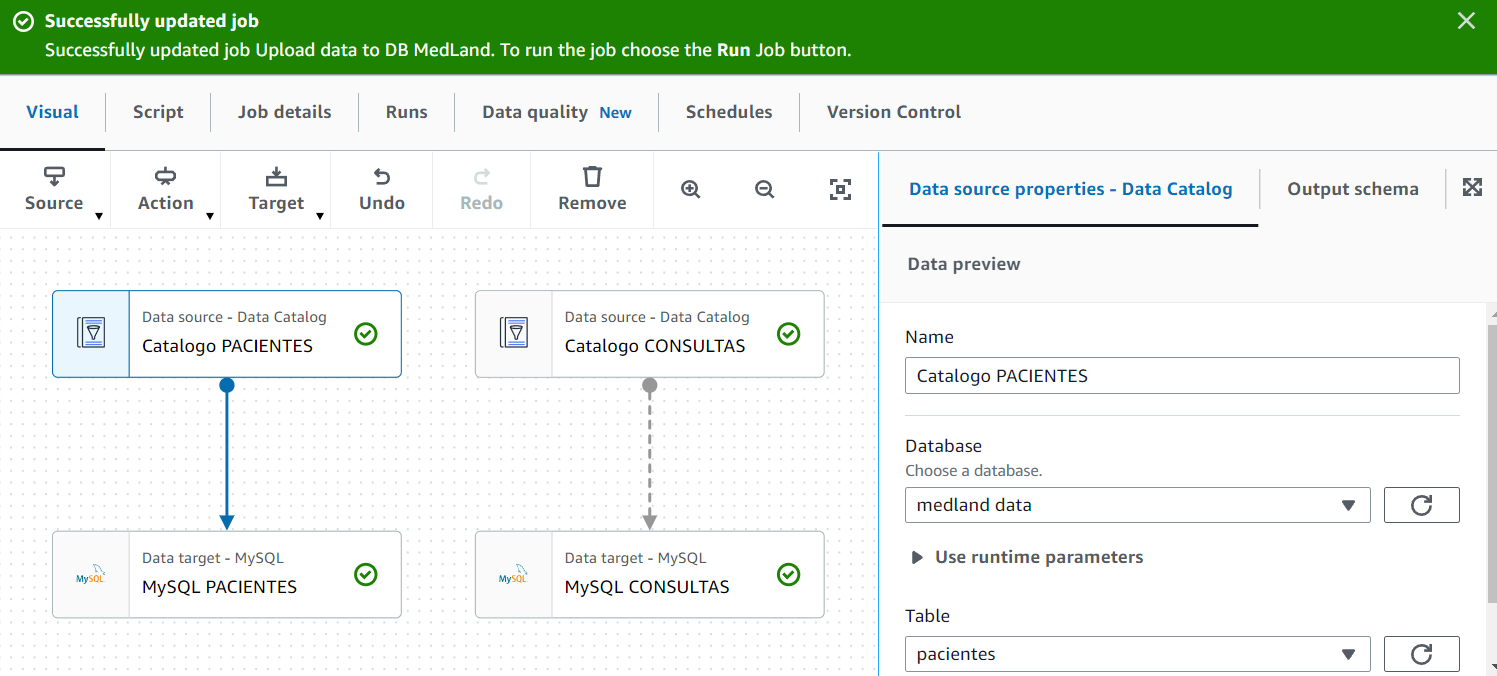

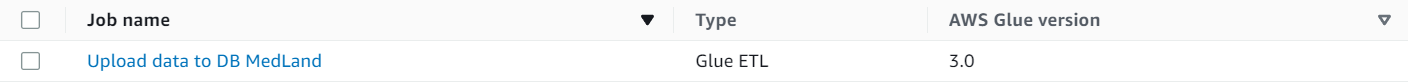

In [34]:
# Rodando segundo job

glue_job2 = ("Upload data to DB MedLand")
run_glue_job(glue_job2)

Job run ID: jr_8a46d8f6192a40aedcf9ac664f9c05f464a53df43a12f20bf5338f13f787b866 at Sun, 17 Sep 2023 01:10:31 GMT
Finished status: SUCCEEDED


## Finalizando!

Lembra do dataframe Pandas `df_inter` criado anteriormente para a tabela internação? Agora com o JOB concluído podemos inserir os dados na tabela.

In [35]:
# Percorre as linhas do DataFrame
for index, row in df_inter.iterrows():
    id_consulta = row['ID_CONSULTA']
    quarto = row['QUARTO']
    entrada = row['ENTRADA']
    saida = row['SAIDA']
    
    # Executa a instrução SQL
    cursor.execute("""
                    INSERT INTO INTERNACOES (ID_INTERNACAO, ID_CONSULTA, QUARTO, ENTRADA, SAIDA) 
                    VALUES (NULL, %s, %s, %s, %s)""", (id_consulta, quarto, entrada, saida)
                  )
    
    # Confirma as alterações
    connection.commit()

In [36]:
# Verificando total de linhas inseridas
query_int = "SELECT count(*) FROM INTERNACOES"
cursor.execute(query_int)
results = cursor.fetchall()

print(f'Total de linhas adicionadas: {results[0][0]}')

Total de linhas adicionadas: 486


In [37]:
# Fechar o cursor e a conexão
cursor.close()
connection.close()